# Table of contents
1. [Introduction](#introduction)
2. [Import images](#import)
3. [Golgi](#Golgi)
    1. [Golgi-ROI](#Golgi-ROI)
        1. [Spray can "feature"](#spraycan)
        2. [Removing spray can](#spraycan-removal)
    2. [Image thresholding](#Golgi-thresholding)
    3. [Clustering via DBSCAN](#Golgi-clustering)
    4. [Region properties](#Golgi-properties)
4. [Nucleus](#Nucleus)

     

## Introduction to Golgi Polarization at Wound Edge <a name="introduction"></a>

The Golgi responds to experimental wounding by re-orientating ("polarizing"), so our main priority is an angular distribution. 

Properties of the cell nucleus and golgi will be a nice sanity check for data quality. 

The animal ID, number of hours, imageID, and properties described above will be saved in a [tidy data format](https://en.wikipedia.org/wiki/Tidy_data) and exported to a csv file. 

## Plan of attack

1. Import tiff stacks into Python
2. ROI detection/selection
    - Use spray can values with DBSCAN
    - Remove spray can feature   
3. Golgi
    - Issues
        - Large spray can 
            - Solved by discriminatating on radius
        - Beads for purifying/separating endothelial cells
            - Programatically unsolved; will be flagged in a visual inspection.
        - Multiple clusters
            - Half-solved by selecting the cluster closest to wound edge. Sometimes DBSCAN doesn't correctly group Golgi fragments together, and there's a tiny part which is closer to the edge. 
        - Different spray can values at times 2hrs, 4hrs, 6hrs
            - Solved by introducing variable histogram range. 
    - Selection
        - Image segmentation with Otsu's Method
        - DBSCAN clustering
4. Nucleus
    - Issues
        - Overlapping nuclei
            - Solved using selection steps below
    - Selection
        - Binary: Otsu's Method
        - Distance transform
        - Mark maxima
        - Watershed segmentation
5. Export data
    - Convert to a pandas DataFrame
    - Save as csv

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import matplotlib.colors as colors

### Ensuring pretty plots ###
plt.style.use('ggplot')
plt.rc('axes', titlesize = 22)
plt.rc('axes', labelsize = 22)
plt.rc('xtick', labelsize = 15)
plt.rc('ytick', labelsize = 15)

## Importing tiff stacks into Python <a name="import"></a>

We are given directories of "marked" tiff images. 

We use `skimage.io.imread()` to load files containing three 16-bit channels (**Green, Blue, Red**). Respectively, they show **Golgi, cell nuclei, and cadherin**.

Not all image readers can understand tiffs with multiple images. RGB image loaders frequently assume that your image is 8-bit where your values range 0 to 255. 


dtype:uint16, shape:(2044, 2048, 3), min:404, max:65535


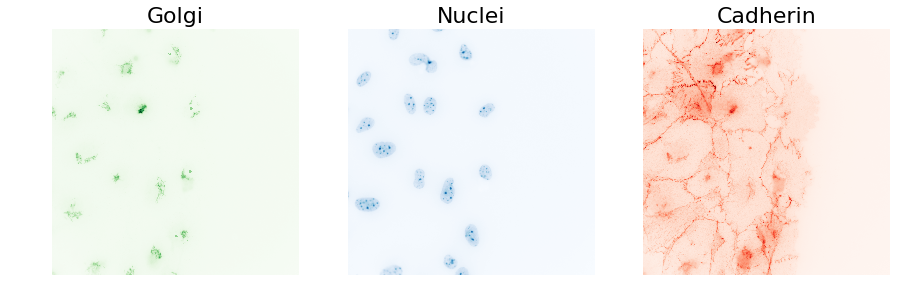

In [2]:
### Importing tiff stack images with skimage.io.imread
from skimage import io

#imdir = 'C:/Users/letmedoit/endothelial Polarization-exp 1/processeddata/Animal-1-4hrs-marked/'
imdir = '../data/processed_images/exp-4/Animal-1-2hrs-marked/'
# loads to numpy array
imarrayGBR = io.imread(imdir + 'Animal 1_2hrs_004-edit.tif')


print("dtype:{}, shape:{}, min:{}, max:{}".format(
    imarrayGBR.dtype, imarrayGBR.shape, imarrayGBR.min(), imarrayGBR.max()))

### N.B. The order is green, blue, red
colors = ['Greens', 'Blues', 'Reds']
names = ['Golgi', 'Nuclei', 'Cadherin']

## Plotting under this line ##
fig, ax = plt.subplots(1, 3, figsize=(15,15))

for i, (color, name) in enumerate(zip(colors, names)):
    ax[i].imshow(imarrayGBR[:,:,i], cmap=color)
    ax[i].set_title(name)
    ax[i].set_axis_off()

In [3]:
def show_image(image_array, color = 'gray', title = '', vmax = None):
    colors_and_cmaps = {'gray':'gray', 'green':'Greens',
                      'blue':'Blues', 'red':'Reds'}
    plt.figure(figsize = (9, 9))
    plt.imshow(image_array,
               vmax = vmax,
               cmap = colors_and_cmaps[color])
    plt.xlabel('Pixel [x]')
    plt.ylabel('Pixel [y]')
    plt.title(title)
    plt.axis('off')
    plt.colorbar()

## Golgi

The Golgi apparatus (hereafter simply referred to as the Golgi) is the equivalent of an Amazon warehouse for proteins. When cells detect a wound, the Golgi should polarize to reduce the distance to the wound edge.

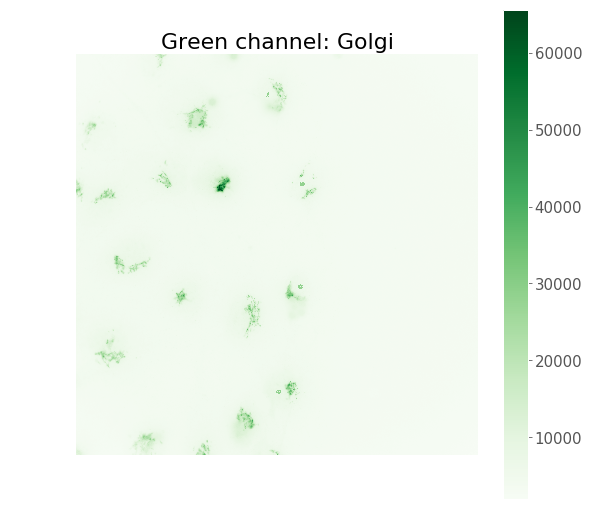

In [5]:
# The first image in the tif stack is green
image_array = imarrayGBR[:,:,0] 

show_image(image_array, color='green', title='Green channel: Golgi')

## ROI designation

Cells along the wound edge ought to polarize in response to the cut, so they were destructively marked with a *specific pixel intensity* by a collaborator using Fiji's spray paint tool. __Unfortunately, the spray can pixel intensity varies file to file.__

Fortunately, these are 16-bit images which means there are $2^{16}$ or 65536 possible intensity values. The pixel intensity of the spray can ought to be clearly visible on on a histogram of pixel intensities; a binary selection of the spray painted values should be clearly visible.

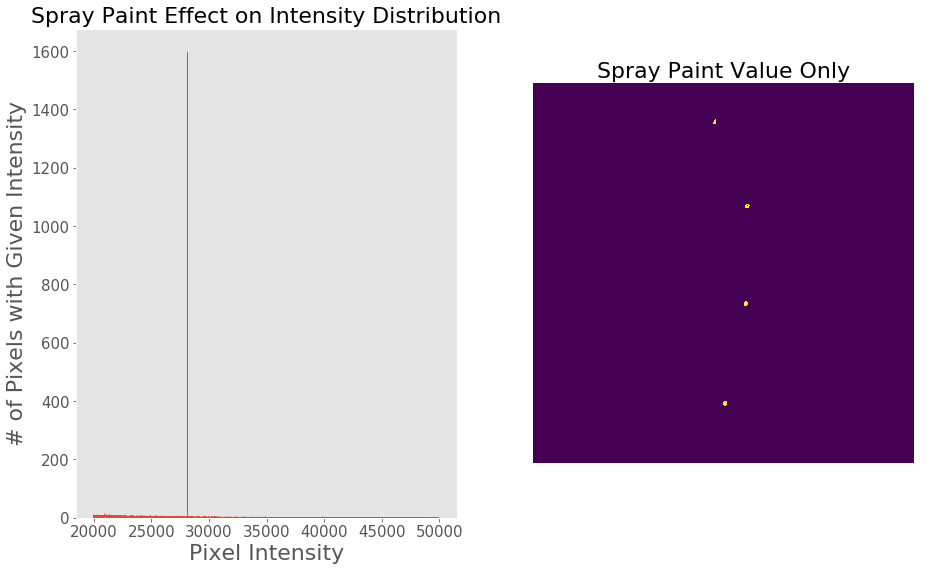

In [11]:
fig, ax = plt.subplots(1,2, figsize=(15,9))

n, bins, _ = ax[0].hist(image_array.flatten(),
                            range=(20000,50000),
                            bins=30000,
                            histtype='step')

ax[0].set_xlabel('Pixel Intensity')
ax[0].set_ylabel('# of Pixels with Given Intensity')
ax[0].set_title('Spray Paint Effect on Intensity Distribution')
ax[0].grid('off')

# Within the range (1500,3500), the spray-can intensity
# is found the most and can be selected this way  
spray_value = int(bins[n.argmax()])

# mask to select pixels matching spray-can value
spray_array = image_array == spray_value

ax[1].imshow(spray_array)

ax[1].set_title('Spray Paint Value Only')
ax[1].set_xlabel('Pixel [x]')
ax[1].set_ylabel('Pixel [y]')
ax[1].set_axis_off()

In [12]:
def get_spray_can_value(green_image_array, pixel_range=(1500,5000)):
    """Returns [int], the most probable pixel intensity for spraycan
    
    Keyword arguments
    --------------------    
    green_image_array [2D array]
        The image channel (green) marked with spraycan
        
    pixel_range [tuple]
        The range of intensity values.
        Make sure your range avoids the absolute maxima
    """
    image_array = np.array(green_image_array)
    
    n, bins = np.histogram(image_array.flatten(),
                            range = pixel_range,
                            bins = pixel_range[1] - pixel_range[0]
                           )
    plt.close()
    spray_value = int(bins[n.argmax()])
    
    return spray_value

Currently `sprayarray` is a 2D boolean array. We want to get the indices where the values are True, and we'll use the indices as (x,y) pairs for cluster analysis. 

In [13]:
x,y = np.where(spray_array==True)
X = np.array((x,y)).T

print('X.shape: {}'.format(X.shape))
print('X: {}'.format(X))

X.shape: (1597, 2)
X: [[ 194  971]
 [ 194  972]
 [ 194  976]
 ..., 
 [1734 1032]
 [1734 1034]
 [1734 1035]]


### Determine amount of cells with DBSCAN

DBSCAN requires two parameters
- $\epsilon$, the maximum distance between two samples for them to be considered as in the same neighborhood
- `min_samples`, the number of samples in a neighborhood for a point to be considered as a core point. This includes the point itself

These values are chosen so that each spray-can selection will be picked up; random pixels with the same intensity as the spray-can won't be misidentified.

In [14]:
## Thanks to dbscan documentation
## http://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html

from sklearn.cluster import DBSCAN
db = DBSCAN(eps=50, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
unique_labels = set(labels)

# Number of clusters in labels, ignoring noise if present
n_clusters_ = len(unique_labels) - (1 if -1 in labels else 0)

print('Estimated number of clusters: {}'.format(n_clusters_))
print('Unique labels: {}'.format(unique_labels))

Estimated number of clusters: 4
Unique labels: {0, 1, 2, 3}


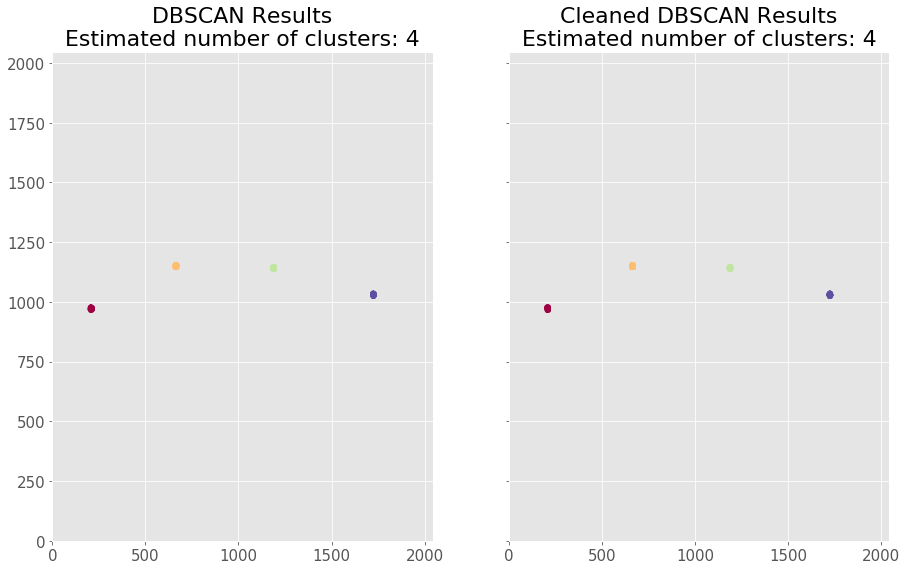

In [15]:
fig, ax = plt.subplots(1,2, figsize=(15,9),
                       sharex=True,sharey=True)

spray_paint_centers = []
max_spray_size = 60 #pixels
# the actual sprays are ~21 pixels wide, so this is generous
bad_labels = [-1]

colors = [plt.cm.Spectral(each)
         for each in np.linspace(0,1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    class_member_mask = (labels == k)
    
    xy = X[class_member_mask & core_samples_mask]
    ax[0].plot(xy[:,0], xy[:,1], 'o', markerfacecolor=tuple(col),
        markeredgecolor=tuple(col), markersize=1)
    
    if k != -1:        # Ignore noise
        dx = np.max(xy[:,0]) - np.min(xy[:,0])
        dy = np.max(xy[:,1]) - np.min(xy[:,1])
        #print(dx, dy)
        if max(dx,dy) < max_spray_size:
            ax[1].plot(xy[:,0], xy[:,1], 'o', markerfacecolor=tuple(col),
            markeredgecolor=tuple(col), markersize=1)
            
            spray_paint_centers.append(
                [np.rint( np.min(xy[:,0]) + dx/2)  ,
                 np.rint( np.min(xy[:,1]) + dy/2)])
        else:
            badlabels.append(k)    

    xy = X[class_member_mask & ~core_samples_mask]
    ax[0].plot(xy[:,0], xy[:,1], 'o', markerfacecolor='k',
            markeredgecolor='k', markersize=1)
    

ax[0].set_xlim([0, image_array.shape[0]])
ax[0].set_ylim([0, image_array.shape[1]])

ax[0].set_title(
    'DBSCAN Results\nEstimated number of clusters: {}'.format(
        n_clusters_))
ax[1].set_title(
    'Cleaned DBSCAN Results\nEstimated number of clusters: {}'.format(
        n_clusters_))

#ax[0].set_axis_off()
#ax[1].set_axis_off()
spray_paint_center_array = np.array(spray_paint_centers).astype(int)

If you're paying attention, you'll realize that this plot looks similar to the previous image.
The origin for this plot is lower-left while the origin for the image is at the upper-left. This is a minor annoyance and can be managed; let's demonstrate that we understand how to go back to an image.

(-0.5, 2047.5, 2043.5, -0.5)

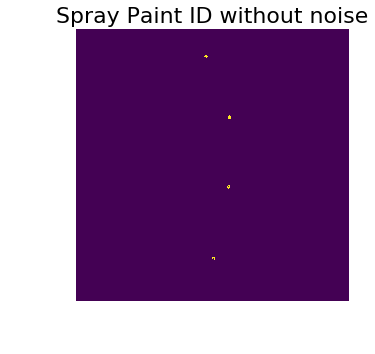

In [16]:
good_labels = ~np.in1d(labels, bad_labels)
good_X = X[good_labels]

to_be_filled = np.zeros_like(spray_array)
to_be_filled[good_X[:,0], good_X[:,1]] = 1
rotated_XY = np.rot90(to_be_filled, 0)

## Plotting under this line ##
plt.figure(figsize=(5,5))

plt.imshow(rotated_XY)

plt.title('Spray Paint ID without noise')
plt.xlabel('Pixel [x]')
plt.ylabel('Pixel [y]')
plt.axis('off')

In [17]:
def binary_cluster_to_image_array(similarly_shaped_array, cluster_values):
    to_be_filled = np.zeros_like(similarly_shaped_array)
    to_be_filled[cluster_values[:,0], cluster_values[:,1]] = 1
    rotated_array =  np.rot90(to_be_filled, 0)
    
    return rotated_array

In [18]:
def get_ROI_pixels(image_array, center, ROI_side=222):
    """Return a box section of your original image array 
    
    Keyword arguments
    --------------------
    imagearray: [array]
        The image array to be sectioned
        
    center: [list] or [tuple] 
        pixel coordinates of ROI centroid given as either 
        a list [x,y] or a tuple (x,y)  
        
    ROIside: [int] (default: 222 pixels)
        side length in pixels of desired box 
    """
    assert ROI_side % 2 == 0, "Give an even ROIside"
    
    # Make a copy instead of referencing original
    new_image = np.array(image_array)
    
    halfside = ROI_side/2
    x = center[0]
    y = center[1]
    
    ## These min/max statements ensure the array
    ## indices stay in bounds of the image.
    maxX = new_image.shape[0]
    maxY = new_image.shape[1]
    
    upper = min(int(x + halfside), maxX)
    lower = max(int(x - halfside), 0)
    right = min(int(y + halfside), maxY)
    left  = max(int(y - halfside), 0)
    
    ## Ensure these values are even
    if (upper - lower) % 2 != 0:
        upper -= 1
    if (right - left) % 2 != 0:
        right -= 1
    
    return new_image[lower:upper, left:right]

### Removing Spray Paint from the image

In [19]:
def remove_spray_can_feature(image_array, spray_can_value):
    """Returns an image array where the pixels with spraycanvalue are
    mapped to another value
    
    Keyword arguments
    --------------------
    imagearray: [array]
        The image array to be sectioned
        
    spraycanvalue: [int]
        An integer value to be removed and replaced by the median of the image
    """ 
    # Make a copy instead of referencing original
    new_image = np.array(image_array)
    
    flat_ROI = new_image.flatten()
    
    ROI_median = np.percentile(flat_ROI, 50)
    #ROI_new_val = np.percentile(flat_ROI, 25)
    
    spray_mask = new_image == spray_can_value
    new_image[spray_mask] = ROI_median
    
    return new_image

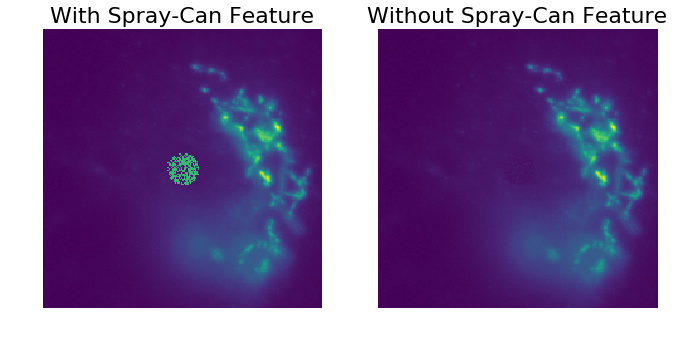

In [20]:
# From the entire image, select the region of interest.
first_ROI = get_ROI_pixels(image_array, spray_paint_centers[0])

# Remove the spray-can feature from the region of interest
ROI_no_spray = remove_spray_can_feature(image_array=first_ROI,
                                     spray_can_value=spray_value)

## Plotting under this line ##
fig, ax = plt.subplots(1,2, figsize=(11,11))

ax[0].imshow(first_ROI)
ax[0].set_title('With Spray-Can Feature')
ax[0].set_axis_off()

ax[1].imshow(ROI_no_spray)
ax[1].set_title('Without Spray-Can Feature')
ax[1].set_axis_off()

Now that our ROI is corrected, we can start processing it.

We will take a look at a handful of different image thresholding techniques:
- Otsu's method
- Yen
- Li

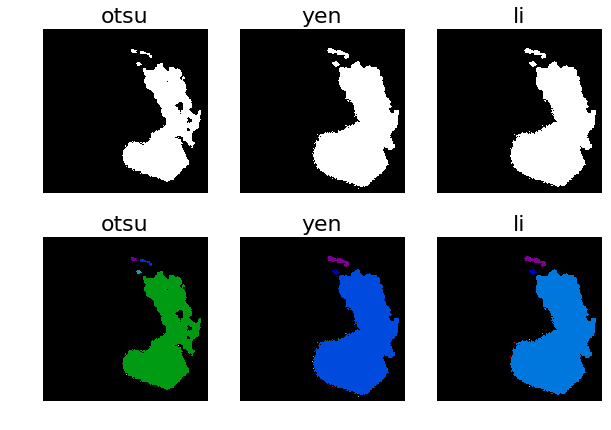

In [21]:
from skimage import filters
from skimage import measure

val_otsu = filters.threshold_otsu(ROI_no_spray)
val_yen = filters.threshold_yen(ROI_no_spray)
val_li  = filters.threshold_li(ROI_no_spray)

names = ['otsu', 'yen', 'li']
methods = [val_otsu, val_yen, val_li]

all_labels_list = []
masks = []

for method in methods:
    mask = ROI_no_spray > method
    masks.append(mask)

    all_labels = measure.label(mask, connectivity=2, background=0)
    all_labels_list.append(all_labels)


## Plotting under this line ##
fig, ax = plt.subplots(2, 3, figsize=(10,7))
ax = ax.ravel()

for i, (name, mask, label) in enumerate(zip(names, masks, all_labels_list)):
    ax[i].imshow(mask, cmap='gray')
    ax[i+3].imshow(label, cmap='nipy_spectral')

    ax[i].set_title(name)
    ax[i+3].set_title(name)
    ax[i].grid('off')
    ax[i+3].grid('off')
    ax[i].set_axis_off()
    ax[i+3].set_axis_off()

After discussion with the domain expert, we chose to go with Otsu's method since its segmentation agrees best in several cases.

The Golgi appears to be disjointed even though it's all one thing. We can use DBSCAN to combine them into one cluster.


Estimated number of clusters: 2
Unique labels: {0, 1}


Text(0.5,1,'Estimated number of clusters: 2')

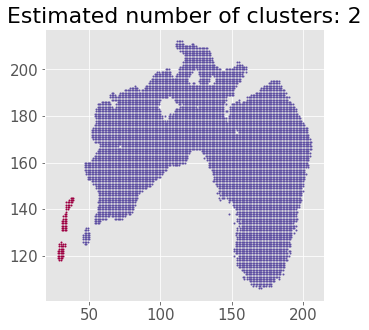

In [22]:
otsu_mask = ROI_no_spray > val_otsu

# At this point otsu_mask is a 2D boolean array
# We must convert it into x,y pairs
xotsu, yotsu = np.where(otsu_mask==True)
XYotsu = np.array((xotsu, yotsu)).T

## Start DBSCAN
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=10, min_samples=10).fit(XYotsu)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
unique_labels = set(labels)

# Number of clusters in labels, ignoring noise if present
n_clusters_ = len(unique_labels) - (1 if -1 in labels else 0)

print('Estimated number of clusters: {}'.format(n_clusters_))
print('Unique labels: {}'.format(unique_labels))

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
plt.figure(figsize=(5,5))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = XYotsu[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor=tuple(col), markersize=1)

    xy = XYotsu[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=1)

plt.title('Estimated number of clusters: %d' % n_clusters_)

Recall that the image-coordinate system has the origin at top-left with y increasing down. A (clockwise) 90-degree rotation is needed to go from this "normal" convention back to image-convention. The transformation for a point is actually (x,y) -> (y,x).

For example, in this coordinate system, higher y-values are actually "more to the right" in the image-convention

Since these cells were chosen as edge cases and the wound is to the right, we can exploit this knowledge to select the correct cluster. 

I will do calculations here and rotate the final image.
You can do whatever makes you happy.

If you're really into coordinate systems, you might say that the transformation should be (x,y) -> (y, -x). This would be the correct if the y-values in the image-convention were negative. But since they aren't, there's no negative.

In [23]:
# Get the clusters into an easily slicable variable
XYclusters = [XYotsu[labels == label] for label in unique_labels
             if label != -1] # Ignore the noise labels

# Determine the desired Golgi
# knowing that the one we want will have
# the highest Y-value in this coordinate system
maxY = [np.max(cluster[:,1]) for cluster in XYclusters]
golgi = XYclusters[np.argmax(maxY)]

unweighted centroid:[ 133.78410453  163.74130904]


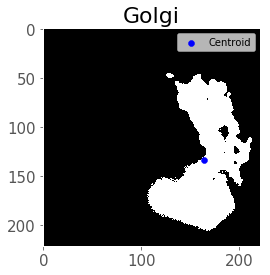

In [24]:
golgi_mean = golgi.mean(axis=0)
print('unweighted centroid:{}'.format(golgi_mean))

to_be_filled = np.zeros_like(ROI_no_spray)
to_be_filled[golgi[:,0], golgi[:,1]] = 1
golgi_rotated = np.rot90(to_be_filled, 0)

# Obtain Golgi properties. 
properties = measure.regionprops(golgi_rotated, cache=False)[0]

area, perimeter, centroid = [properties[key] 
            for key in ['area', 'perimeter','centroid']]

#MICRONS_PER_PIXEL = 0.108

#print(area*MICRONS_PER_PIXEL**2)
#print(perimeter*MICRONS_PER_PIXEL)
#print(centroid)

## Plotting under this line ##

plt.imshow(golgi_rotated, label = 'Nucleus', cmap = 'gray')
# note that the centroid's x and y are switched
plt.scatter(centroid[1], centroid[0], c = 'b', label = 'Centroid')
plt.grid('off')
plt.title('Golgi')
plt.legend()

### Determining centroid of a nucleus



In [25]:
def get_region_properties(region, MICRONS_PER_PIXEL=0.108):
    """Returns region properties (area, perimeter, centroid)
    
    region: [array]
    MICRONS_PER_PIXEL: [float] 
    
    Returns the area and perimeter in microns**2 and microns
    
    Returns the centroid in pixels as defined by the region's
    origin/coordinate system
    """
    properties = measure.regionprops(region, cache=False)[0]

    area, perimeter, centroid = [properties[key] 
                for key in ['area', 'perimeter','centroid']]
    
    area = area*MICRONS_PER_PIXEL**2
    perimeter = perimeter*MICRONS_PER_PIXEL
    
    return area, perimeter, centroid

In [26]:
blue_image_array = imarrayGBR[:,:,1]


In [27]:
#print(spray_paint_centers)

In [28]:
def obtain_nucleus_properties(spray_paint_centers, blue_image_array,
                             want_plots=False, out_dir="",
                             image_name=""):
    """Returns a numpy array of nucleus properties
    
    Keyword arguments
    --------------------
    spray_paint_centers: [1D array with elements [x,y]]
        1D array containing the pixel locations of various ROI centers
        
    blue_image_array: [2D image array]
        2D image array
    
    want_plots: [bool] [optional] [Default: False]
        True if you want to save plots
    
    out_dir: [path] [optional] 
        String containing the directory for plots to be saved
    
    image_name: [str] [optional]
        String for the image filename.
    
    Uses Otsu's Method for image segmentation.
    """
    from scipy import ndimage as ndi
    from skimage.morphology import watershed
    from skimage.feature import peak_local_max

    n_cells = len(spray_paint_centers)
    nucleus_centroid_list = []
    area_list = []
    perimeter_list = []
    
    image_array = np.array(blue_image_array)
    
    if want_plots:
        fig, axes = plt.subplots(2, n_cells, figsize=(16,5),
                                 sharex=True, sharey=True,
                                 subplot_kw={'adjustable':'box-forced'})
        ax = axes.ravel()

    for i, cell in enumerate(spray_paint_centers):
        blue_ROI = get_ROI_pixels(image_array, cell)
        
        # Use Otsu's Method to separate foreground from background
        val_otsu_blue = filters.threshold_otsu(blue_ROI)
        binary_mask_blue = blue_ROI > val_otsu_blue

        # Apply Euclidean Distance Transform to the binary image
        blue_distance = ndi.distance_transform_edt(binary_mask_blue)

        # Obtain the local maxima using distance to the background
        blue_local_maxi = peak_local_max(blue_distance,
                                    min_distance=23, # ~ cell radius in pixels
                                    #exclude_border=True,
                                    indices=False,
                                    labels=binary_mask_blue)

        # Mark the maxima
        blue_markers, nfeatures = ndi.label(blue_local_maxi)

        # Apply watershed segmentation. Don't forget about the negative!
        # The negative is important because `watershed` expects minima
        blue_labels = watershed(-blue_distance, blue_markers,
                           mask = binary_mask_blue)
        
        # background is labeled 0
        blue_cluster_labels = np.delete(np.unique(blue_labels), 0)

        ### Get the pixel indices for the desired nucleus
        
        middle = np.array(list(blue_labels.shape)) / 2

        distance_list = []
        centroid_list = []
        XYnuclei_list = []

        for label in np.unique(blue_cluster_labels):
            x, y = np.where(blue_labels==label)
            XY = np.array((x,y)).T
            XYnuclei_list.append([XY])
            cent = XY.mean(axis=0)
            centroid_list.append(cent)
            distance = np.linalg.norm(np.abs(cent - middle))
            distance_list.append(distance)

        XYnuclei_array = np.array(XYnuclei_list)

        distances = np.array(distance_list)
        min_index = np.argmin(distances)
        nucleus_centroid_list.append(centroid_list[min_index])
        
        ## Rotate selected nucleus
        Xnucleus = binary_cluster_to_image_array(blue_labels,
                                                XYnuclei_array[min_index][0])
        
        # Obtain Nucleus properties. 
        area, perimeter, _ = get_region_properties(Xnucleus)
        area_list.append(area)
        perimeter_list.append(perimeter)
        
        ## Plotting under this line ##
        if want_plots:
            ax[i].imshow(Xnucleus, label='Nucleus', cmap='gray')
            ax[i].scatter(nucleus_centroid_list[i][1],
                          nucleus_centroid_list[i][0],
                          c='b', label='Centroid')
            ax[i+n_cells].imshow(blue_ROI, cmap='gray')
            ax[i+n_cells].grid('off')
            ax[i].grid('off')
        #### end
    if want_plots:
        plt.savefig("{}/{}_{}.png".format(
            out_dir, image_name, "Nuclei"))
        plt.close() # close figure
    
    #print("nucleus within the function: {}".format(nucleus_centroid_list))
    return (np.array(area_list), np.array(perimeter_list),
            np.array(nucleus_centroid_list))

In [29]:
bluecent = obtain_nucleus_properties(spray_paint_centers, blue_image_array)
bluecent

(array([ 112.522608,  118.949472,  116.768304,  165.698784]),
 array([ 49.8546701 ,  44.94675581,  47.06202075,  70.05462073]),
 array([[ 105.36643516,  109.7037421 ],
        [ 123.34712689,  107.40625613],
        [ 114.5379083 ,  105.64998502],
        [ 103.29557933,  103.92622835]]))

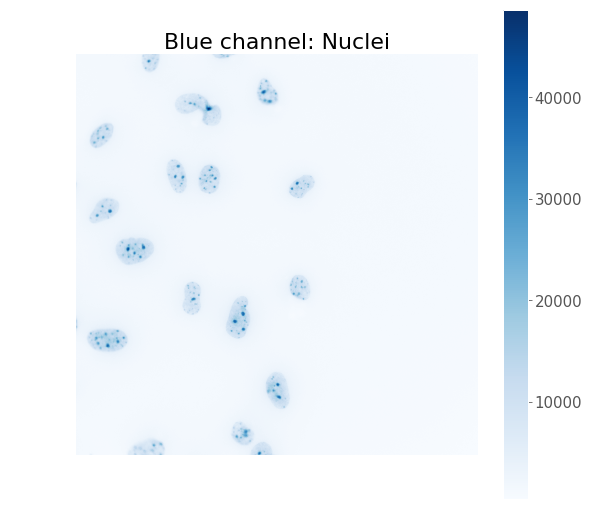

In [31]:
show_image(blue_image_array, color='blue', title='Blue channel: Nuclei')

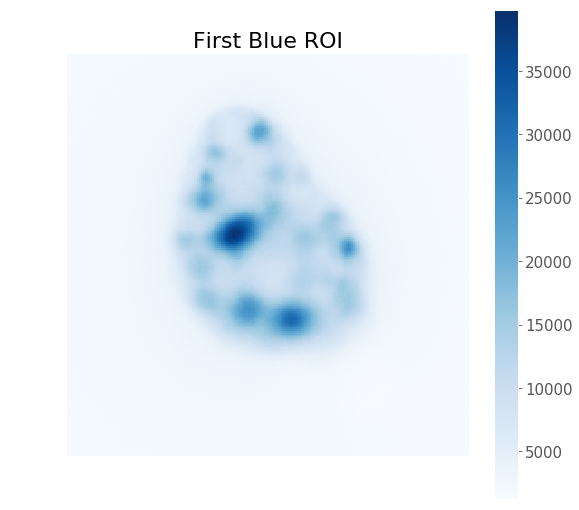

In [33]:
first_blue_ROI = get_ROI_pixels(blue_image_array, spray_paint_centers[0])
show_image(first_blue_ROI, color='blue', title='First Blue ROI')

## Overlapping nuclei require image segmentation
We have overlapping nuclei. Instead of crying and/or ignoring this region, let's get to work.

First we'll do a binary segmentation to separate foreground from background.

Then we'll hit 'em with a watershed segmentation to separate the objects.

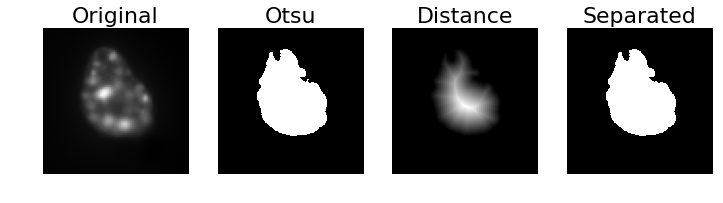

In [34]:
from scipy import ndimage as ndi
from skimage.morphology import watershed
from skimage.feature import peak_local_max

# Use Otsu's Method to separate foreground from background
val_otsu_blue = filters.threshold_otsu(first_blue_ROI)
binary_mask_blue = first_blue_ROI > val_otsu_blue

# Apply Euclidean Distance Transform to the binary image
first_blue_distance = ndi.distance_transform_edt(binary_mask_blue)

# Obtain the local maxima using distance to the background
first_blue_local_maxi = peak_local_max(first_blue_distance,
                                    min_distance=23, # ~ cell radius in pixels
                                    exclude_border=True,
                                    indices=False,
                                    labels=binary_mask_blue)

# Mark the maxima
first_blue_markers, nfeatures = ndi.label(first_blue_local_maxi)

# Apply watershed segmentation. Don't forget about the negative!
# The negative is important because `watershed` expects minima
first_blue_labels = watershed(-first_blue_distance, first_blue_markers,
                           mask = binary_mask_blue)


## Plotting under this line ##

# Group for plotting
first_blue_titles = ['Original', 'Otsu', 'Distance','Separated']
first_blue_to_plot = [first_blue_ROI, binary_mask_blue,
                      first_blue_distance, first_blue_labels]

fig, axes = plt.subplots(1,4, figsize=(12,3), sharex=True, sharey=True,
                        subplot_kw={'adjustable':'box-forced'})
ax = axes.ravel()

for i, (title, method) in enumerate(
                zip(first_blue_titles, first_blue_to_plot)):
    ax[i].axis('off')
    ax[i].imshow(method, cmap='gray')
    ax[i].set_title(title)

Now that we have separate regions, we can calculate centroids and also determine which region is the desired nucleus.

We know that our nucleus is going to be near the center of our image, so let's calculate the centroid for each region and choose the one that is closest.


(-0.5, 221.5, 221.5, -0.5)

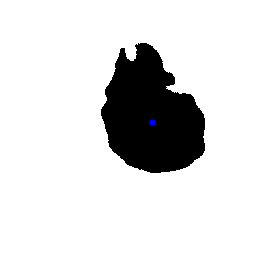

In [36]:
## Get the pixel indices for the desired nucleus
middle = np.array(list(first_blue_labels.shape)) / 2

distance_list = []
centroid_list = []
XYnuclei_list = []

for label in np.unique(first_blue_labels):
    x, y = np.where(first_blue_labels==label)
    XY = np.array((x,y)).T
    XYnuclei_list.append([XY])
    cent = XY.mean(axis=0)
    centroid_list.append(cent)
    distance = np.linalg.norm(np.abs(cent - middle))
    distance_list.append(distance)

XYnuclei_array = np.array(XYnuclei_list)

distances = np.array(distance_list)
minindex = np.argmin(distances)

to_be_filled = np.zeros_like(first_blue_labels)
to_be_filled[XYnuclei_array[minindex][0][:,0],
             XYnuclei_array[minindex][0][:,1]] = 1
X = np.rot90(to_be_filled, 0)

## Plotting under this line ##

plt.imshow(X, label = 'Nucleus', cmap = 'gray')
plt.scatter(centroid_list[minindex][1],
            centroid_list[minindex][0],
            c = 'b',
            label='Centroid',
           )
plt.axis('off')

In [37]:
props = measure.regionprops(X, cache=False)
#### Don't forget to convert these to microns at the end
#print(props[0]['area']*MICRONS_PER_PIXEL**2, props[0]['perimeter'])

In [38]:
#spray_paint_centers

In [39]:
def get_spray_can_centers(green_array, spray_value,
                          want_plots = False,
                          out_dir = "",
                          image_name = ""):
    """Returns an array of [x,y] pairs representing spray can centers
    
    Keyword arguments
    --------------------
    want_plots: [bool] [optional] [Default: False]
        True if you want to save plots
    
    out_dir: [path] [optional] 
        String containing the directory for plots to be saved
    
    image_name: [str] [optional]
        String for the image filename.
    
    """
    
    # mask to select pixels matching spray-can value
    spray_array = green_array == spray_value
    
    # Currently sprayarray is a 2D boolean array.
    # We want to get the indices where the values are True,
    # and we'll use the indices as (x,y) pairs for cluster analysis.
    x, y = np.where(spray_array == True)
    X = np.array((x,y)).T
    
    ## Determine cells with DBSCAN 
    ## http://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html
    
    from sklearn.cluster import DBSCAN
    db = DBSCAN(eps = 50, min_samples = 10).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype = bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    unique_labels = set(labels)
    
    # Number of clusters in labels, ignoring noise if present
    n_clusters_ = len(unique_labels) - (1 if -1 in labels else 0)
    
    spray_can_centers_array = []
    max_spray_size = 60 # pixels
    bad_labels = []
    
    if want_plots:
        fig, ax = plt.subplots(1, 2, figsize = (15, 9),
                               sharex = True, sharey = True)
    
    colors = [plt.cm.Spectral(each)
         for each in np.linspace(0,1, len(unique_labels))]
    
    for k, col in zip(unique_labels, colors):
        class_member_mask = (labels == k)

        xy = X[class_member_mask & core_samples_mask]
        if want_plots:
            ax[0].plot(xy[:,0], xy[:,1], 'o',
                       markerfacecolor=tuple(col),
                       markeredgecolor=tuple(col),
                       markersize=1)

        if k != -1:        # Ignore noise
            dx = np.max(xy[:,0]) - np.min(xy[:,0])
            dy = np.max(xy[:,1]) - np.min(xy[:,1])
            
            # There's a large spray in at least one image
            if max(dx,dy) < max_spray_size:
                if want_plots:
                    ax[1].plot(xy[:,0], xy[:,1], 'o',
                               markerfacecolor=tuple(col),
                               markeredgecolor=tuple(col),
                               markersize=1)

                spray_can_centers_array.append(
                    [np.rint( np.min(xy[:,0]) + dx/2)  ,
                     np.rint( np.min(xy[:,1]) + dy/2)])
            else:
                bad_labels.append(k)    

        xy = X[class_member_mask & ~core_samples_mask]
        
        if want_plots:
            ax[0].plot(xy[:,0], xy[:,1], 'o',
                       markerfacecolor = 'k',
                       markeredgecolor = 'k',
                       markersize = 1,
                      )

    if want_plots:
        ax[0].set_xlim([0, green_array.shape[0]])
        ax[0].set_ylim([0, green_array.shape[1]])

        ax[0].set_title(
            'DBSCAN Results\nEstimated number of clusters: {}'.format(
                n_clusters_))
        
        n_cleaned_clusters_ = len(set(range(n_clusters_)) - set(bad_labels))
        ax[1].set_title(
            'Cleaned DBSCAN Results\nEstimated number of clusters: {}'.format(
                n_cleaned_clusters_))
        
        plt.savefig("{}/{}_{}.png".format(
            out_dir, image_name, "Golgi_spray_paints"))
        plt.close()
    return spray_can_centers_array

In [40]:
def analyze_Golgi_ROI(ROI_no_spray,
                      want_plots = False,
                      out_dir = "",
                      image_name = ""):
    """Returns area [square microns], perimeter [microns] and centroid [pixel]

    Keyword arguments
    --------------------
    ROI_no_spray: [2D array]
        Image array after the spray-can pixels have been masked
        to be something else (e.g. median)
    
    want_plots: [bool] [optional] [Default: False]
        True if you want to save plots
    
    out_dir: [path] [optional] 
        String containing the directory for plots to be saved
    
    image_name: [str] [optional]
        String for the image filename.
    """
    from skimage import filters
    from skimage import measure
    
    # Apply Otsu's method
    val_otsu = filters.threshold_otsu(ROI_no_spray)
    otsu_mask = ROI_no_spray > val_otsu

    # At this point otsu_mask is a 2D boolean array
    # We must convert it into x,y pairs
    xotsu, yotsu = np.where(otsu_mask==True)
    XYotsu = np.array((xotsu, yotsu)).T

    ## Start DBSCAN
    from sklearn.cluster import DBSCAN

    db = DBSCAN(eps = 10, min_samples = 10).fit(XYotsu)
    core_samples_mask = np.zeros_like(db.labels_, dtype = bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    unique_labels = set(labels)

    # Number of clusters in labels, ignoring noise if present
    n_clusters_ = len(unique_labels) - (1 if -1 in labels else 0)

    
    # Get the clusters into an easily slicable variable
    XYclusters = [XYotsu[labels == label] for label in unique_labels
                 if label != -1] # Ignore the noise labels
    
    # Determine the desired Golgi
    # knowing that the one we want will (most likely) have
    # the highest Y-value in this coordinate system
    maxY = [np.max(cluster[:,1]) for cluster in XYclusters]
    golgi = XYclusters[np.argmax(maxY)]
    
    ## Rotate
    golgi_rotated = binary_cluster_to_image_array(ROI_no_spray,
                                                  golgi)
    
    # Obtain Golgi properties. 
    area, perimeter, centroid = get_region_properties(golgi_rotated)
    
    if want_plots:
        fig, ax = plt.subplots(1, 2,
                               figsize = (12, 6),
                               sharex = True,
                               sharey = True,
                              )
        
        ax[0].imshow(ROI_no_spray, cmap = 'gray')
        ax[1].imshow(golgi_rotated, label = 'Golgi', cmap = 'gray')
        # note that the centroid's x and y are switched
        ax[1].scatter(centroid[1], centroid[0],
                      c = 'b', label = 'Centroid')
        ax[0].grid('off')
        ax[1].grid('off')
        ax[0].set_title('ROI')
        ax[1].set_title('Golgi_selection')
        
        plt.savefig("{}{}_{}_{}_{}.png".format(
            out_dir, image_name, "Golgi_centroid",
            round(centroid[1], 1), round(centroid[0], 1) ))
        plt.close()

    return area, perimeter, centroid

In [41]:
def get_range_from_hour_and_exp(image_name, filename):
    """Returns a tuple (range) of values based on the experiment and time point."""
    exp_number = filename.split("/")[3]
    
    if exp_number == "exp-3":
        ranges = [(1500,5500), (1500, 5500), (1500, 5000)]
    elif exp_number == "exp-1":
        ranges = [(1500,5500), (1500, 5500), (10000, 24000)]
    elif exp_number == "exp-4":
        ranges = []
    else:
        ranges = [(0, 5000), [0, 5000], (0, 5000)]
    
    hour = image_name.split(" ")[1].split("_")[1][0]
    hours = ['2', '4', '6']
    mapping = dict(zip(hours, ranges))

    return mapping[hour]

    
        

In [42]:
def analyze_Golgi(green_array, filename, want_plots = False,
                  out_dir = "", image_name = ""):
    """Returns a Golgi class with the following variables:
    - area_list, 
    - perimeter_list, 
    - centroid_list,
    - spray_can_centers_array,
    - ROI_x, ROI_y"""
   
    g = Golgi()
    
    ## The spray-can intensity varies between images at different hours
    spray_can_range = get_range_from_hour_and_exp(image_name, filename)
    
    spray_can_value = get_spray_can_value(green_image_array=green_array,
                                         pixel_range=spray_can_range
                                         )
    
    g.spray_can_centers_array = get_spray_can_centers(green_array,
                                                    spray_can_value,
                                                    want_plots = want_plots,
                                                    out_dir = out_dir,
                                                    image_name = image_name
                                                   )
    
    # Loop over different identified cells
    for spray_can_center in g.spray_can_centers_array:
        
        # From the entire image, select the region of interest.
        ROI = get_ROI_pixels(green_array, spray_can_center)

        # Remove the spray-can feature from the region of interest
        ROI_no_spray = remove_spray_can_feature(image_array = ROI,
                                                spray_can_value = spray_can_value
                                               )
        
        # Analyze Golgi ROI to get area, perimeter, centroid
        area, perimeter, centroid, = analyze_Golgi_ROI(
            ROI_no_spray,
            want_plots = want_plots,
            out_dir = out_dir,
            image_name = image_name
        )
        
        # Save values to be returned
        g.area_list.append(area)
        g.centroid_list.append(centroid)
        g.perimeter_list.append(perimeter)
        g.ROI_x_list.append(ROI.shape[0])
        g.ROI_y_list.append(ROI.shape[1])
    
    return g

In [43]:
import numpy as np
import numpy.linalg as LA
from sklearn.cluster import DBSCAN


def angles_from_points(A, B, origin):
    """ Returns the angles [rad] between two points. 
    
    Keyword arguments:
    A: a 1-D numpy array with elements in the form [x,y]
    B: a 1-D numpy array with elements in the form [x,y]
    origin: a 1-D numpy array with elements in the form [x,y]
    
    We use the dot product between two vectors A and B
    to determine the angle between them. DO NOT USE OUTSIDE
    OF THIS NOTEBOOK.
    
    N.B. we assume that A contains the coordinates for the 
    Golgi centroids. 
    """
    maxY = np.max(A[:,1])
    
    ## Transform to image system
    # Reverse order (x,y) -> (y,x)
    A_prime = np.array([ [c[1], c[0]] for c in A])
    B_prime = np.array([ [maxY, c[0]] for c in B])
    origin = np.array([ [c[1], c[0]] for c in B])
    
    
    A_vectors = A_prime - origin
    B_vectors = B_prime - origin
    
    magA = LA.norm(A_vectors, axis=1)
    magB = LA.norm(B_vectors, axis=1)
    
    dotAB = np.sum(A_vectors*B_vectors, axis=1)
    
    cosTheta = dotAB / (magA*magB)
    
    # Compare y-values to see whether the angle should be negative
    Ay_greater_than_By = np.greater(A_vectors[:,1], B_vectors[:,1]) 

    signs = np.array([-1 if bool_val else 1 
                     for bool_val in Ay_greater_than_By])
    
    return signs*np.arccos(cosTheta)

In [ ]:
import numpy as np
import numpy.linalg as LA
import glob
import os
import pandas as pd
from skimage import io
from skimage import filters
from skimage import measure
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from scipy import ndimage as ndi

class Golgi:
    """Golgi class for an image file with multiple ROIs
    
    Attributes:
        area_list:      list of Golgi areas in pixels
        centroid_list:  list of Golgi centroid locations in pixels
        perimeter_list: list of Golgi perimeters in pixels
        ROI_x_list:     list of ROI length in pixels
        ROI_y_list:     list of ROI height in pixels
        
    """
    def __init__(self):
        self.area_list = []
        self.centroid_list = []
        self.perimeter_list = []
        self.ROI_x_list = []
        self.ROI_y_list = []


def main():
    processed_data_dir = "../data/processed_images/"
    exp_list = os.listdir(processed_data_dir) # ['exp-1', 'exp-3']
    
    for exp in exp_list:
        data_dir = processed_data_dir + exp + "/"

        ### Create a directory for output files 
        output_dir = '../csvfiles/'
        if not os.path.isdir(output_dir):
            os.mkdir(output_dir)

        ### Given a directory, get all of the image files.
        image_file_list = glob.glob(data_dir + '**/*.tif')
        # ['...\\Animal-1-2hrs-marked\\Animal 1_2hrs_003-edit.tif', ...]

        image_file_list = [imagefile.replace('\\', '/')
                      for imagefile in image_file_list]
        # ['.../Animal-1-2hrs-marked/Animal 1_2hrs_003-edit.tif', ...]
        
        image_ID_list = [image.split("/", -1)[-1].split("-edit.tif")[0]
                   for image in image_file_list]
        # ['Animal 1_2hrs_003', ...]

        
        ### Initialize the lists for holding output data
        nucleus_centroid_list = []
        nucleus_area_list = []
        nucleus_perimeter_list = []
        golgi_centroid_list = []
        spray_can_centroid_list = []
        golgi_area_list = []
        golgi_perimeter_list = []
        file_id_list = []

        n_files = len(image_file_list)
        ROI_x_list = []
        ROI_y_list = []

        ### loop through the images
        for i, (image, image_ID) in enumerate(zip(image_file_list, image_ID_list)):

            # counter to track progress
            if (i % 10) == 0:
                print("{}/{}".format(i, n_files))
            print(image)

            # The order of the tiff stack goes Green, Blue, Red
            image_array_GBR = io.imread(image)

            ### Green/Golgi
            green_array = image_array_GBR[:,:,0]

            #areas, perimeters, centroids, spray_can_centers_array, ROI_x, ROI_y = analyze_Golgi(
            g = analyze_Golgi(green_array,
                              filename = image,
                              want_plots = False,
                              out_dir = output_dir,
                              image_name = image_ID,
                             )

            for g_a, g_p, g_c in zip(g.area_list, g.perimeter_list, g.centroid_list):
                golgi_area_list.append(g_a)
                golgi_perimeter_list.append(g_p)
                golgi_centroid_list.append(g_c)

            del green_array

            #### Blue/Nuclei
            blue_array = image_array_GBR[:,:,1]

            nucleus_properties = obtain_nucleus_properties(
                g.spray_can_centers_array,
                blue_array,
                want_plots = False,
                out_dir = output_dir,
                image_name = image_ID)

            (nu_areas, nu_perimeters, nu_centroids) = nucleus_properties

            for (nu_a, nu_c, nu_p) in zip(nu_areas, nu_centroids, nu_perimeters):
                nucleus_area_list.append(nu_a)
                nucleus_perimeter_list.append(nu_p)
                nucleus_centroid_list.append(nu_c)
                file_id_list.append(image_ID)

            ROI_x_list.extend(g.ROI_x_list)
            ROI_y_list.extend(g.ROI_y_list)

            del blue_array

        nuclei_centroids = np.array(nucleus_centroid_list)
        golgi_centroids = np.array(golgi_centroid_list)
        ROI_x_array = np.asarray(ROI_x_list)
        ROI_y_array = np.asarray(ROI_y_list)

        spray_paint_centroids = np.stack((ROI_x_array / 2, ROI_y_array / 2),
                                         axis = -1)
        
        angles = angles_from_points(golgi_centroids,
                                    nuclei_centroids,
                                    spray_paint_centroids)

        ### Combine the data into a dataframe
        d = {'fileID' : file_id_list,
            'nucleiCentroidsXInPixels' : nuclei_centroids[:,0],
            'nucleiCentroidsYInPixels' : nuclei_centroids[:,1],
            'golgiCentroidsXInPixels' : golgi_centroids[:,0],
            'golgiCentroidsYInPixels' : golgi_centroids[:,1],
            'ROICentroidsXInPixels' : spray_paint_centroids[:,0],
            'ROICentroidsYInPixels' : spray_paint_centroids[:,1],
            'golgiAreaInSquareMicrons' : golgi_area_list,
            'golgiPerimeterInMicrons' :  golgi_perimeter_list,
            'anglesInRad' : angles,
            'anglesInDeg' : angles*180./np.pi,
            'nucleiAreaInSquareMicrons' : nucleus_area_list,
            'nucleiPerimeterInMicrons' :  nucleus_perimeter_list
            }

        df = pd.DataFrame(data = d)

        csvfilename = os.path.join('../csvfiles/',
                                   "{}data.csv".format(exp))

        # round to two decimal places
        df.round(2).to_csv(csvfilename, index = False)
    
if __name__ == '__main__':
    main()